In [1]:
import sys
sys.path.append('../scripts')
import pandas as pd
import proplot as pplt
import os
from helpers import *

In [2]:
%run ../scripts/choose_buoys.py

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


P110
P093
P104
P118
P094
P092
P099
P103
P100
P108
P112
P117
P095
P107
P091
P097
P113
P114
P106
P115
P105
P096
P119
P111
P109
P102
P090
P101
P098
CO3
P120


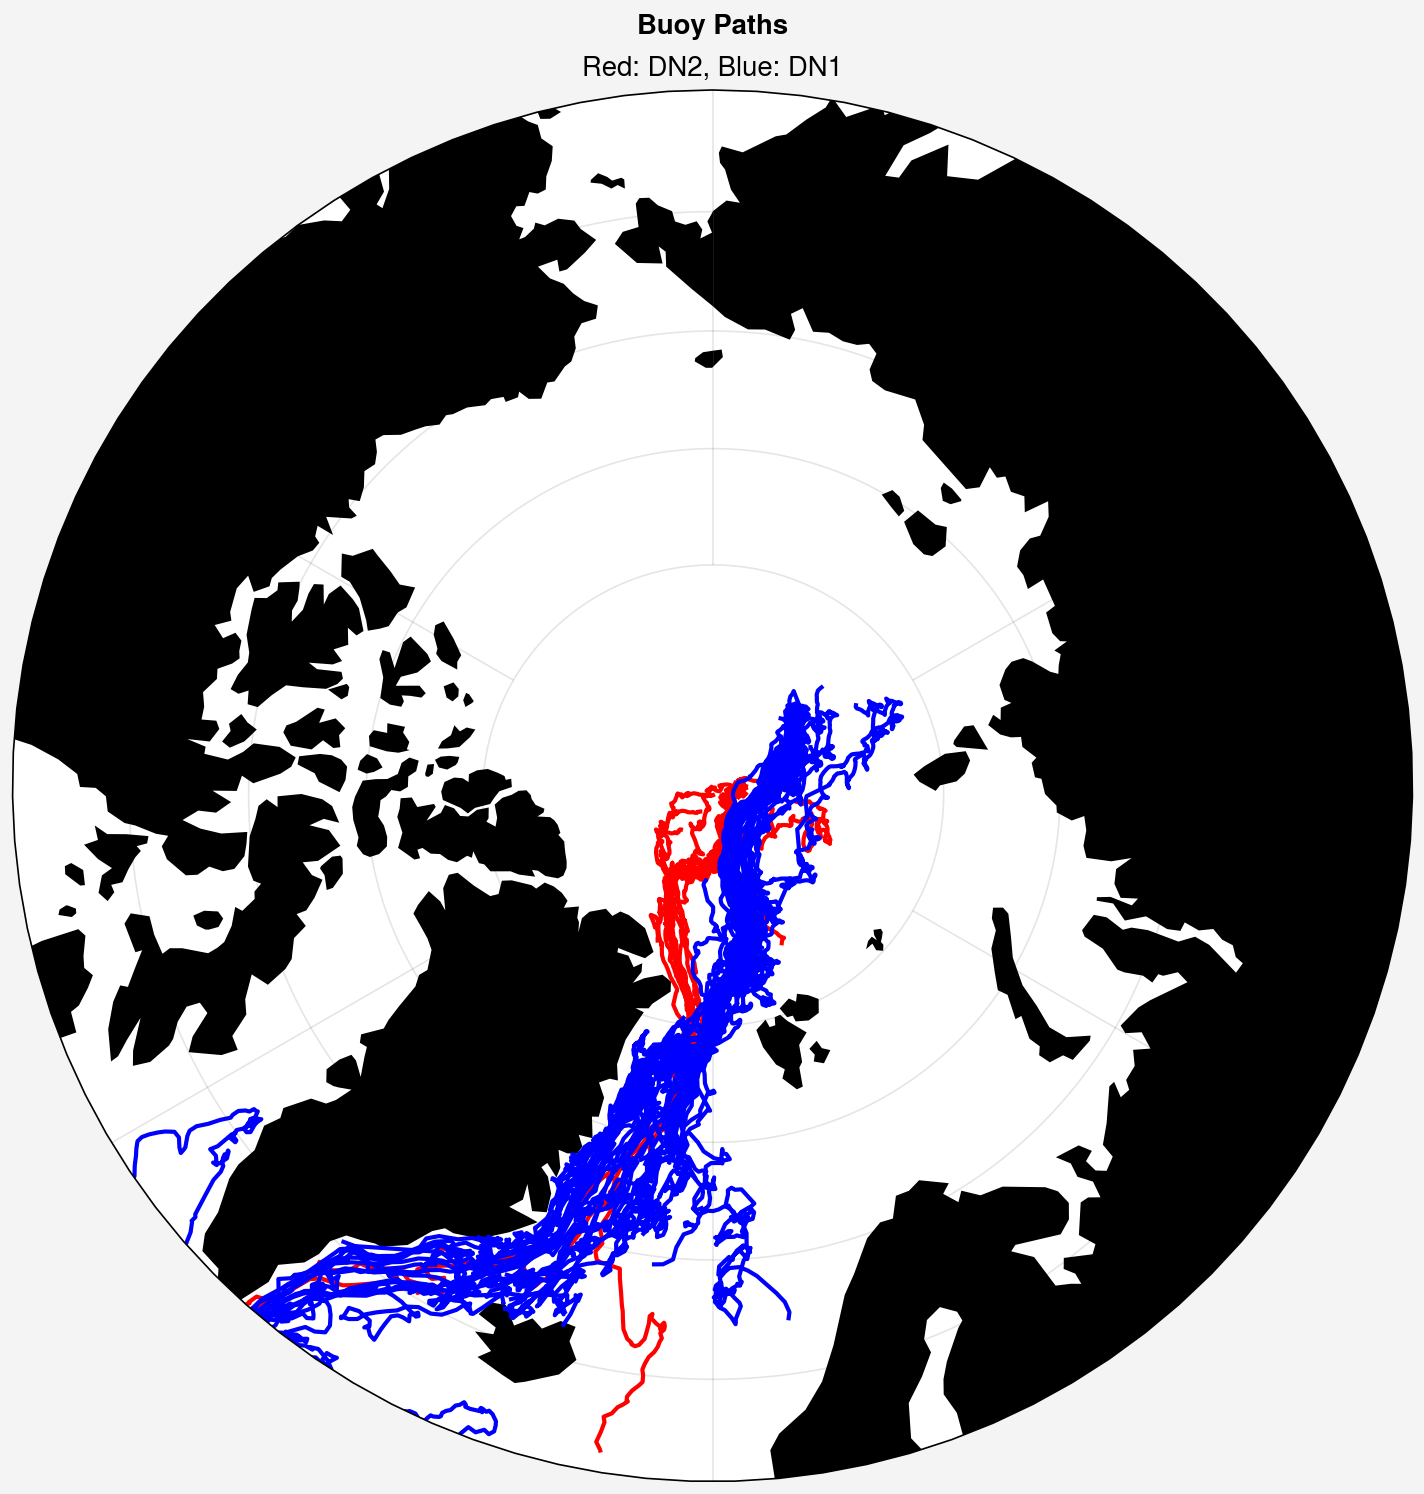

In [3]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/daily_stations/mosaic_dn1")
dn2 = os.listdir("../data/daily_stations/mosaic_dn2")

axs[0].format(boundinglat=60, title='Red: DN2, Blue: DN1')

# Plot dn2 buoys in red, dn1 buoys in blue
for station in [i[:-4] for i in dn2]:
    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="red")
for station in [i[:-4] for i in dn1]:
    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="blue")